In [1]:
import torch #import necessary for data processing
import numpy as np 
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import csv
import nerfvis
from nerfvis import scene

In [2]:
def eval_spherical_function(k, d): #evaluates parametric spherical function with inputs k and d
    x, y, z = d[..., 0:1], d[..., 1:2], d[..., 2:3]

    # Modified from https://github.com/google/spherical-harmonics/blob/master/sh/spherical_harmonics.cc
    return 0.282095 * k[..., 0] + \
        - 0.488603 * y * k[..., 1] + 0.488603 * z * k[..., 2] - 0.488603 * x * k[..., 3] + \
        (1.092548 * x * y * k[..., 4] - 1.092548 * y * z * k[..., 5] + 0.315392 * (2.0 * z * z - x * x - y * y) * k[
               ..., 6] + -1.092548 * x * z * k[..., 7] + 0.546274 * (x * x - y * y) * k[..., 8]) #Evualuate the Function, stolen from google to retrive spherical harmonics

In [3]:
def eval_gaussian_spherical_function(k, d):
    # Coordinates
    x, y, z = d[..., 0:1], d[..., 1:2], d[..., 2:3]
    sigma = 1.0
    
    # Calculate the squared distance from the origin for Gaussian modulation
    r_squared = x**2 + y**2 + z**2
    
    # Gaussian modulation term, adjust 'sigma' for the spread of the Gaussian
    gaussian_modulation = np.exp(-r_squared / (2 * sigma**2))
    
    # Spherical Harmonics with Gaussian modulation
    return gaussian_modulation * (
        0.282095 * k[..., 0] + \
        - 0.488603 * y * k[..., 1] + 0.488603 * z * k[..., 2] - 0.488603 * x * k[..., 3] + \
        (1.092548 * x * y * k[..., 4] - 1.092548 * y * z * k[..., 5] + 
         0.315392 * (2.0 * z * z - x * x - y * y) * k[..., 6] + 
         -1.092548 * x * z * k[..., 7] + 0.546274 * (x * x - y * y) * k[..., 8])
    )


In [4]:
class NerfModel(nn.Module): #used to predict coefficients K. Kinda like a hypernetwork N is the size of the voxel grid. Scale gives the sclae of the grid in meters.
    def __init__(self, N=256, scale=1.5): #256 can be doubled or tripled to increase clarity? 
        """
        :param N
        :param scale: The maximum absolute value among all coordinates for objects in the scene
        """
        super(NerfModel, self).__init__() #Constructor of the superclass

        self.voxel_grid = nn.Parameter(torch.ones((N, N, N, 27 + 1)) / 100) #Initalizes the model, 3D Grid N by N by N. Each cell stores 28 values. 27 (k) is spherical harmonics, 1 is density. 1e-2 is used to initalize, can be changed for better results.
        self.scale = scale
        self.N = N

    def forward(self, x, d, dirs=None): #Forward Function. Taking input of position on a direction.
        color = torch.zeros_like(x) #Predicts color and density at location
        sigma = torch.zeros((x.shape[0]), device=x.device) 
        mask = (x[:, 0].abs() < self.scale) & (x[:, 1].abs() < self.scale) & (x[:, 2].abs() < self.scale) #Only predicts color and density of points within the voxel grid as defined by the model. Points outside are 0

        idx = (x[mask] / (2 * self.scale / self.N) + self.N / 2).long().clip(0, self.N - 1) #Create a voxel grid at position x
        tmp = self.voxel_grid[idx[:, 0], idx[:, 1], idx[:, 2]] #Extract density 
        sigma[mask], k = torch.nn.functional.relu(tmp[:, 0]), tmp[:, 1:] #Extract k aka spherical harmonics coefficeints 
        color[mask] = eval_spherical_function(k.reshape(-1, 3, 9), d[mask]) #Gets color at said points
        return color, sigma #Returns the color and the density 
    

In [5]:
@torch.no_grad()
def test(hn, hf, dataset, chunk_size=10, img_index=0, nb_bins=250, H=400, W=400): #Takes in input on hn and hf influence on farpoints for parametric integration. Size needed to avoid out of memory error. Img index. NB are number of bins for parametric integration. H and W are image size.
    ray_origins = dataset[img_index * H * W: (img_index + 1) * H * W, :3] #Origin of ray based on datasete and image index
    ray_directions = dataset[img_index * H * W: (img_index + 1) * H * W, 3:6] #Direction of ray based on dataset and image index

    data = [] #Rending ray
    for i in range(int(np.ceil(H / chunk_size))):
        ray_origins_ = ray_origins[i * W * chunk_size: (i + 1) * W * chunk_size].to(device) #render the ray
        ray_directions_ = ray_directions[i * W * chunk_size: (i + 1) * W * chunk_size].to(device) #render the director
        regenerated_px_values = render_rays(model, ray_origins_, ray_directions_, hn=hn, hf=hf, nb_bins=nb_bins) #Append regenerated value to data 
        data.append(regenerated_px_values) #Appends the value 
    img = torch.cat(data).data.cpu().numpy().reshape(H, W, 3) #Saves to an image

    plt.figure()
    plt.imshow(img)
    plt.savefig(f'Imgs/img_{img_index}p.png', bbox_inches='tight')
    plt.close()

In [14]:
@torch.no_grad() #Annoyed that test was saving snippets to a file, alternate version of test that does not same image to a file 
def test2(hn, hf, dataset, chunk_size=10, img_index=0, nb_bins=64, H=400, W=400):
    ray_origins = dataset[img_index * H * W: (img_index + 1) * H * W, :3]
    ray_directions = dataset[img_index * H * W: (img_index + 1) * H * W, 3:6]

    data = []
    for i in range(int(np.ceil(H / chunk_size))):
        ray_origins_ = ray_origins[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        ray_directions_ = ray_directions[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        regenerated_px_values = render_rays(model, ray_origins_, ray_directions_, hn=hn, hf=hf, nb_bins=nb_bins)
        data.append(regenerated_px_values)
    img = torch.cat(data).data.cpu().numpy().reshape(H, W, 3)

    plt.figure()
    plt.imshow(img)
    

In [6]:
def compute_accumulated_transmittance(alphas): #Q3, Ti, light transmiited through ray
    accumulated_transmittance = torch.cumprod(alphas, 1)
    return torch.cat((torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device),
                      accumulated_transmittance[:, :-1]), dim=-1)

In [7]:
def render_rays(nerf_model, ray_origins, ray_directions, hn=0, hf=0.5, nb_bins=192): #Takes in model (3d Representation of the world), the ray direction and origin, and hn/hf for parametric integration
    device = ray_origins.device
    t = torch.linspace(hn, hf, nb_bins, device=device).expand(ray_origins.shape[0], nb_bins) #Sample t, sample points along the line hn and hf, helps training for each ray and makes them uniformly spaced
    # Perturb sampling along each ray.
    mid = (t[:, :-1] + t[:, 1:]) / 2. #Helps introduce noise to help uniform spacing. 
    lower = torch.cat((t[:, :1], mid), -1)
    upper = torch.cat((mid, t[:, -1:]), -1)
    u = torch.rand(t.shape, device=device)
    t = lower + (upper - lower) * u  # [batch_size, nb_bins]
    delta = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor([1e10], device=device).expand(ray_origins.shape[0], 1)), -1)

    x = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(1)  # [batch_size, nb_bins, 3]
    ray_directions = ray_directions.expand(nb_bins, ray_directions.shape[0], 3).transpose(0, 1) #3D location of sample points, where will it be at time t. Gives 3D location. 

    colors, sigma = nerf_model(x.reshape(-1, 3), ray_directions.reshape(-1, 3)) #calls model to get prediction for x direction
    colors = colors.reshape(x.shape) #Gives color
    sigma = sigma.reshape(x.shape[:-1]) #Gives density 

    alpha = 1 - torch.exp(-sigma * delta)  # [batch_size, nb_bins] Gets alpha
    weights = compute_accumulated_transmittance(1 - alpha).unsqueeze(2) * alpha.unsqueeze(2) #Gets weights 
    c = (weights * colors).sum(dim=1)  # Pixel values
    weight_sum = weights.sum(-1).sum(-1)  # Regularization for white background
    return c + 1 - weight_sum.unsqueeze(-1) #Regularization because the background is white


In [8]:
def train(nerf_model, optimizer, scheduler, data_loader, device='cpu', hn=0, hf=1, nb_epochs=int(1e6), #runs like a standard model. NB_epochs for which we train
          nb_bins=250):
    training_loss = []
    for _ in range(nb_epochs): #for each epoch we iterate over the dataset
        for batch in tqdm(data_loader): #iterate over data loader, makes cool progress bar
            ray_origins = batch[:, :3].to(device) #gets origin 
            ray_directions = batch[:, 3:6].to(device) #gets direction 
            ground_truth_px_values = batch[:, 6:].to(device) #gets ground truth value. Kinda like controlled learning. 

            regenerated_px_values = render_rays(nerf_model, ray_origins, ray_directions, hn=hn, hf=hf, nb_bins=nb_bins) #Append regenerated value to data 
            loss = torch.nn.functional.mse_loss(ground_truth_px_values, regenerated_px_values)

            optimizer.zero_grad() #calls optimizer to update weights
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())

        scheduler.step()
    return training_loss

In [9]:
def export_voxel_grid(model, filepath="voxel_grid.csv"):
    """
    Exports the voxel grid to a CSV file.
    
    :param model: The trained NerfModel instance.
    :param filepath: Path to the output CSV file.
    """
    with open(filepath, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['x', 'y', 'z', 'sigma', 'r', 'g', 'b'])

        voxel_grid = model.voxel_grid.detach().cpu().numpy()  # Ensure it's on CPU and converted to numpy
        N = model.N  # Resolution of the voxel grid
        scale = model.scale  # Scale of the model

        for i in range(N):
            for j in range(N):
                for k in range(N):
                    # Compute normalized coordinates [-scale, scale]
                    x = (i / N) * 2 * scale - scale
                    y = (j / N) * 2 * scale - scale
                    z = (k / N) * 2 * scale - scale
                    
                    voxel = voxel_grid[i, j, k]
                    sigma = voxel[0]  # Density or sigma value
                    color = voxel[1:4]  # RGB color
                    
                    # Write voxel data to CSV
                    writer.writerow([x, y, z, sigma, *color])

In [10]:
def save_model(model, optimizer, epoch, filepath): #Commands for the model
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, filepath)

In [11]:
if __name__ == "__main__":
    device = 'cuda'
    training_dataset = torch.from_numpy(np.load('training_data.pkl', allow_pickle=True))
    testing_dataset = torch.from_numpy(np.load('testing_data.pkl', allow_pickle=True))
    model = NerfModel(N=169).to(device)
    model_optimizer = torch.optim.Adam(model.parameters(), lr=1e-2) #learning rate high, directly otimizing voxel grid
    scheduler = torch.optim.lr_scheduler.MultiStepLR(model_optimizer, milestones=[2, 4, 8], gamma=0.5) #Decays learning rate as epochs gets higher

    data_loader = DataLoader(training_dataset, batch_size=4096, shuffle=True)
    train(model, model_optimizer, scheduler, data_loader, nb_epochs=1, device=device, hn=2, hf=6, nb_bins=250)
    for img_index in [0]:
        test(2, 6, testing_dataset, img_index=img_index, nb_bins=256, H=400, W=400)
    #save_model(model, model_optimizer, nb_epochs, "ModelTest2.pt") #MAKE SURE TO INCREMENT MODELTEST EACH TIME YOU MAKE A NEW MODEL JAYAL. 
    #export_voxel_grid(model, filepath="output_voxel_grid.csv")

100%|██████████| 3907/3907 [2:33:30<00:00,  2.36s/it]     
c:\Users\jyots\PycharmProjects\JailPlexnoels\.venv\Lib\site-packages\svox\helpers.py:371: UserWarning: CUDA extension svox.csrc could not be loaded! Operations will be slow.
Please do not import svox in the SVOX source directory.
  warn("CUDA extension svox.csrc could not be loaded! " +


* Discretizing NeRF (requires torch, tqdm, svox, scipy)
  Evaluating NeRF on a grid
   Note: using SH projection


  0%|          | 0/350 [00:00<?, ?it/s]


TypeError: NerfModel.forward() missing 1 required positional argument: 'd'

In [16]:
checkpoint_path = 'ModelTest1.pt' #Commands used to run the pre-trained model
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))
model.load_state_dict(checkpoint['model_state_dict'])
model_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.to(torch.device('cuda'))

NerfModel()

In [17]:
scene = nerfvis.Scene("ModelTest")
scene.add_nerf("NeRF", model, center=[0.0, 0.0, 0.0], radius=1.5, use_dirs=True)
scene.add_axes()
scene.display(port=8889)

* Discretizing NeRF (requires torch, tqdm, svox, scipy)
  Evaluating NeRF on a grid
   Note: using SH projection


  0%|          | 0/350 [00:00<?, ?it/s]


TypeError: NerfModel.forward() missing 1 required positional argument: 'd'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


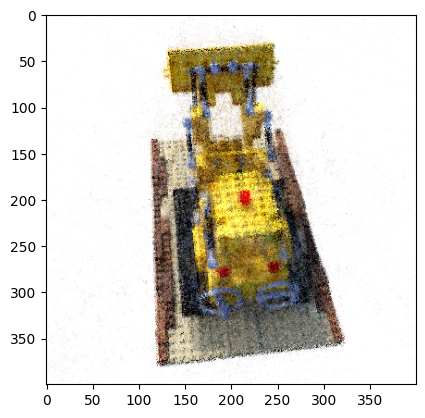

In [15]:
#train(model, model_optimizer, scheduler, data_loader, nb_epochs=1, device=device, hn=2, hf=6, nb_bins=250)
test2(2,6, testing_dataset, img_index=198, nb_bins=64, H=400, W=400)